# `asyncmd.trajectory.SlurmTrajectoryFunctionWrapper`

The `asyncmd.trajectory.SlurmTrajectoryFunctionWrapper` can wrap any executable that works on the trajectories underlying the `asyncmd.Trajectory` objects. The wrapped executable is turned into an asyncronously callable subprocess and as for the functions in the `PyTrajectoryFunctionWrapper`, the results are cached for each trajectory such that reapplying a function is cheap. `SlurmTrajectoryFunctionWrapper` will submit the execution via SLURM and thereby enables the use of multiple cores distributed over multiple nodes when applying the same function to multiple different trajectories at once. The executable is expected to take the path to the trajcetory and structure files on the command line, any user specified command line flags and arguments can also be passed though. Please have a look at the docstring of the `SlurmTrajectoryFunctionWrapper` for more.

We will use the `SlurmTrajectoryFunctionWrapper` here to wrap the state and desscriptor functions for capped alanine dipeptide. The content of the file `ala_cv_funcs.py` is printed below. Please have a look at the functions we import to make sure you understand what they return. Beeing able to write functions that can be used on your molecular system of interest yourself is the key to use `asyncmd` to its full potential.

In addition to the state functions you should have a look at the code for parsing command line arguments. This is the magic bit that converts the python function into an executable. You could of course also use any other (non-python) executable that takes trajectory files on the command line as required. Additionally the executable either needs to write out its results as numpy npz file or you must define a custom loading function that will be called with a filename as argument and is expected to return a numpy array with the results. The custom loading function option enables you to write out the results to disk in any (custom) format as long as you can find or write a function to read it.

### Imports

In [1]:
%matplotlib inline

In [2]:
import os
import asyncio
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import asyncmd
from asyncmd import trajectory as asynctraj

/u/hejung/conda-envs/asyncmd_workshop_10_2024/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Have a look at the state and descriptor functions

In [4]:
# this is just to have a look at the file content
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython

with open('../resources/ala_cv_funcs.py') as f:
    code = f.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, PythonLexer(), formatter)))

### Create the wrapped state functions
As you hopefully have guessed from the code above each state functions returns one value for every frame in the trajectory, i.e. their output is expected to be of shape `(len(trajectory),)` and the values simply indicate whether each frame is to be considered part of the respective state (`True`) or not (`False`).

When called via the command line the code will write out the results to `args.output_file` as numpy npz file. This is then automatically loaded by `asyncmd` and we do not have to define a custom loading function.

The script will be called via the sbatch_script, which is printed below. It is very minimal and depending on the configuration of the cluster you are running on, you probably want to add at least a partition to ensure that you are not blocking a whole node for the 1 core we are requesting to run the CV calculation.

In [5]:
from pygments.lexers import BashLexer

with open('../resources/ala_calc_cvs.slurm') as f:
    code = f.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, BashLexer(), formatter)))

In [6]:
C7_eq_wrapped = asynctraj.SlurmTrajectoryFunctionWrapper(executable="../resources/ala_cv_funcs.py",
                                                         sbatch_script="../resources/ala_calc_cvs.slurm",
                                                         call_kwargs={"--function": "C7eq",
                                                                      "--skip": 1,
                                                                      },
                                                        )
# the optional call_kwargs argument can be used to specify additional keyword arguments
# [we pass skip=1 which does not do anything because it is the default value only to show that call_kwargs exists]
alpha_R_wrapped = asynctraj.SlurmTrajectoryFunctionWrapper(executable="../resources/ala_cv_funcs.py",
                                                           sbatch_script="../resources/ala_calc_cvs.slurm",
                                                           call_kwargs={"--function": "alphaR",
                                                                        "--skip": 1,
                                                                        },
                                                           )

### Load two different configurations as `asyncmd.Trajectory`

In [7]:
# create an asyncmd.Trajectory of the initial configuration from the `GmxEngine.ipynb` notebook
conf_in_alphaR = asyncmd.Trajectory(trajectory_files="../resources/gromacs/capped_alanine_dipeptide/conf_in_alphaR.trr",
                                    structure_file="../resources/gromacs/capped_alanine_dipeptide/conf.gro",
                                    )
# create a second asyncmd.Trajectory of another configuration (in another state)
conf_in_C7eq = asyncmd.Trajectory(trajectory_files="../resources/gromacs/capped_alanine_dipeptide/conf_in_C7eq.trr",
                                  structure_file="../resources/gromacs/capped_alanine_dipeptide/conf.gro",
                                  )

### Apply the state functions to both configurations/trajectories simultaneously
We use `asyncio.gather` as usual to collect multiple tasks/coroutine executions and execute them all at once via SLURM.

In [8]:
import time
states = [alpha_R_wrapped, C7_eq_wrapped]

start = time.time()
states_for_conf_in_alphaR = await asyncio.gather(*(sf(conf_in_alphaR) for sf in states))
states_for_conf_in_C7eq = await asyncio.gather(*(sf(conf_in_C7eq) for sf in states))
end = time.time()

print(f"States (alphaR, C7_eq) for conf_in_alphaR: {states_for_conf_in_alphaR}.")
print(f"States (alphaR, C7_eq) for other_conf: {states_for_conf_in_C7eq}.")
print(f"The calculation took {round(end-start, 4)} seconds")

States (alphaR, C7_eq) for conf_in_alphaR: [array([ True]), array([False])].
States (alphaR, C7_eq) for other_conf: [array([False]), array([ True])].
The calculation took 20.22 seconds


### Applying the state functions again, we can observe that the result is obtained much faster because it has been cached
The caching applies to all wrapped functions, i.e. the return values of all wrapped functions operating on `asyncmd.Trajectory` objects are cached. This means that all (potentially costly) functions operating on a trajectory will have to be evaluated only once (the first time they are called), even if called multiple places in the code (e.g. because the order of execution was yet undetermined).

In [9]:
start = time.time()
states_for_conf_in_alphaR = await asyncio.gather(*(sf(conf_in_alphaR) for sf in states))
states_for_conf_in_C7eq = await asyncio.gather(*(sf(conf_in_C7eq) for sf in states))
end = time.time()

print(f"States (alphaR, C7_eq) for conf_in_alphaR: {states_for_conf_in_alphaR}.")
print(f"States (alphaR, C7_eq) for other_conf: {states_for_conf_in_C7eq}.")
print(f"The calculation took {round(end-start, 4)} seconds")

States (alphaR, C7_eq) for conf_in_alphaR: [array([ True]), array([False])].
States (alphaR, C7_eq) for other_conf: [array([False]), array([ True])].
The calculation took 0.0053 seconds


### Chain the application of TrajectoryFunctionWrappers

Depending on your collective variable functions it can make sense to cache (computationally costly) intermediate results. An example would be two states that are defined in terms of the same desciptors. This is the case for the $\alpha_R$ and $C7_{eq}$ states, which are both defined in terms of the two dihedrals $\psi$ and $\phi$. We will demonstrate the chaining of TrajectoryFunctionWrappers here by reimplementing the two state functions `alpha_R` and `C7_eq` on top of the output of the wrapped function `descriptor_func_psi_phi`.

In [10]:
psi_phi_wrapped = asynctraj.SlurmTrajectoryFunctionWrapper(executable="../resources/ala_cv_funcs.py",
                                                           sbatch_script="../resources/ala_calc_cvs.slurm",
                                                           call_kwargs={"--function": "descriptors_psi_phi",
                                                                        "--skip": 1,
                                                                        },
                                                           )

### (Re)define the state functions in $\psi$ and $\phi$

Using the two functions below, the (wrapped) `descriptor_func_psi_phi` will only be called once per trajectory even if we call both state functions. In addition we can also wrap the newly defined asyncronous functions to cache their results as usual by passing them to a `PyTrajectoryFunctionWrapper`.

In [11]:
async def alpha_R_redef(traj):
    # phi: -pi < phi < 0
    # psi: -50 degree < psi < 30 degree
    psi_phi = await psi_phi_wrapped(traj)
    psi, phi = psi_phi[:, 0], psi_phi[:, 1]
    state = np.zeros((len(traj),), dtype=bool)
    deg = 180/np.pi
    state[(phi <= 0) & (-50/deg <= psi) & (psi <= 30/deg)] = True
    return state

async def C7_eq_redef(traj):
    # phi: -pi -> 0
    # psi: 120 -> 200 degree
    psi_phi = await psi_phi_wrapped(traj)
    psi, phi = psi_phi[:, 0], psi_phi[:, 1]
    state = np.zeros((len(traj),), dtype=bool)
    deg = 180/np.pi
    state[(phi <= 0) & ((120/deg <= psi) | (-160/deg >= psi))] = True
    return state

In [12]:
# applying the second state function should be much faster since it will use the cached intermediate results for φ and ψ
confs = [conf_in_alphaR, conf_in_C7eq]

start = time.time()
results_alphaR_redef = await asyncio.gather(*(alpha_R_redef(conf) for conf in confs))
end = time.time()
print(f"alpha_R results for both configurations are: {results_alphaR_redef}.")
print(f"The calculation took {round(end-start, 4)} seconds")

start = time.time()
results_C7eq_redef = await asyncio.gather(*(C7_eq_redef(conf) for conf in confs))
end = time.time()
print(f"C7_eq results for both configurations are: {results_C7eq_redef}.")
print(f"The calculation took {round(end-start, 4)} seconds")

alpha_R results for both configurations are: [array([ True]), array([False])].
The calculation took 10.1302 seconds
C7_eq results for both configurations are: [array([False]), array([ True])].
The calculation took 0.0015 seconds


In [13]:
# wrapping the redefined state functions works as usual

alpha_R_redef_wrapped = asynctraj.PyTrajectoryFunctionWrapper(alpha_R_redef)
C7_eq_redef_wrapped = asynctraj.PyTrajectoryFunctionWrapper(C7_eq_redef)

# and applying them to trajectories too
states = [alpha_R_redef_wrapped, C7_eq_redef_wrapped]

start = time.time()
states_for_conf_in_alphaR = await asyncio.gather(*(sf(conf_in_alphaR) for sf in states))
states_for_conf_in_C7eq = await asyncio.gather(*(sf(conf_in_C7eq) for sf in states))
end = time.time()
print(f"States (alphaR, C7_eq) for conf_in_alphaR: {states_for_conf_in_alphaR}.")
print(f"States (alphaR, C7_eq) for other_conf: {states_for_conf_in_C7eq}.")
print(f"The calculation took {round(end-start, 4)} seconds")

# Here again the second application should be slightly faster due to caching
start = time.time()
states_for_conf_in_alphaR = await asyncio.gather(*(sf(conf_in_alphaR) for sf in states))
states_for_conf_in_C7eq = await asyncio.gather(*(sf(conf_in_C7eq) for sf in states))
end = time.time()
print(f"Running the same 'calculation' again took {round(end-start, 4)} seconds...we just retrieved the results from cache once again.")

States (alphaR, C7_eq) for conf_in_alphaR: [array([ True]), array([False])].
States (alphaR, C7_eq) for other_conf: [array([False]), array([ True])].
The calculation took 0.0038 seconds
Running the same 'calculation' again took 0.0014 seconds...we just retrieved the results from cache once again.


### Plot the two configurations in the plane of $\phi$ and $\psi$
We will use the wrapped `descriptor_func_psi_phi` and plot the results.

In [14]:
vals_in_alphaR, vals_in_C7eq = await asyncio.gather(psi_phi_wrapped(conf_in_alphaR), psi_phi_wrapped(conf_in_C7eq))

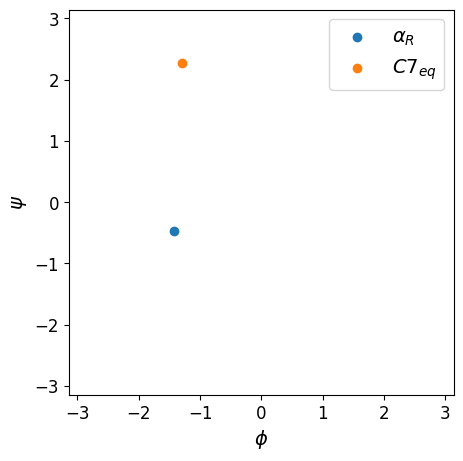

In [15]:
fig, axs = plt.subplots(figsize=(5,5))

axs.scatter(vals_in_alphaR[:, 1], vals_in_alphaR[:, 0], label="$\\alpha_R$")
axs.scatter(vals_in_C7eq[:, 1], vals_in_C7eq[:, 0], label="$C7_{eq}$")


axs.set_xlim(-np.pi, np.pi)
axs.set_ylim(-np.pi, np.pi)
axs.set_xlabel("$\\phi$", size=14)
axs.set_ylabel("$\\psi$", size=14)
axs.tick_params(labelsize=12)
axs.set_aspect("equal")
axs.legend(fontsize=14)